In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras import layers
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from transformers import AutoTokenizer
import torch
from transformers import BertForSequenceClassification
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


2024-05-29 14:31:01.652026: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-29 14:31:04.499215: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Load all data

In [2]:
df = pd.read_parquet('/users/a/c/achawla1/main/lumos-data/data/annots/annotated_data.parquet')

In [3]:
# clean data
df = df[~df['sentiment'].str.contains('nan')]
df = df[df['sentiment'] != 'maybe']
df = df.drop_duplicates(subset='text')
df['sentiment_encoded'] = df.sentiment.map({'yes': 1, 'no': 0})

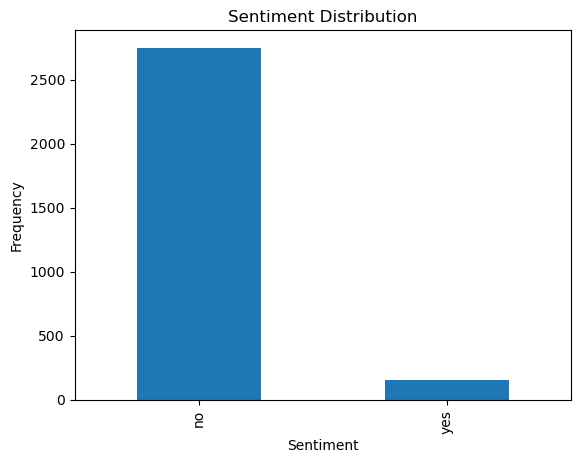

In [4]:
# plot distribution of sentiment
df.sentiment.value_counts().plot(kind='bar')
# show labels and axis
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Sentiment Distribution')
plt.show()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment_encoded'], test_size=0.2, random_state=42)

## SVM

In [6]:
model = make_pipeline(TfidfVectorizer(), SVC())
model.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()), ('svc', SVC())])

In [7]:
y_pred = model.predict(X_test)
print(model.score(X_test, y_test))
print(classification_report(y_test, y_pred))

0.9569707401032702
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       551
           1       1.00      0.17      0.29        30

    accuracy                           0.96       581
   macro avg       0.98      0.58      0.63       581
weighted avg       0.96      0.96      0.94       581



## Naive Bayes

In [8]:
# use naive bayes 
model = make_pipeline(TfidfVectorizer(), MultinomialNB())
model.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [9]:
y_pred = model.predict(X_test)
print(model.score(X_test, y_test))
print(classification_report(y_test, y_pred))

0.9483648881239243
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       551
           1       0.00      0.00      0.00        30

    accuracy                           0.95       581
   macro avg       0.47      0.50      0.49       581
weighted avg       0.90      0.95      0.92       581



/users/a/c/achawla1/miniconda3/envs/llama_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/users/a/c/achawla1/miniconda3/envs/llama_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/users/a/c/achawla1/miniconda3/envs/llama_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

## DNN - CNN

In [13]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

In [14]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [15]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

embedding_dim = 50

In [37]:
model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

/users/a/c/achawla1/miniconda3/envs/llama_env/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [38]:
model.fit(X_train, y_train, epochs=10, verbose=False, validation_data=(X_test, y_test), batch_size=10)

In [39]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

Training Accuracy: 0.9974


In [40]:
# get confusion matrix
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
0.963855421686747
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       551
           1       0.80      0.40      0.53        30

    accuracy                           0.96       581
   macro avg       0.88      0.70      0.76       581
weighted avg       0.96      0.96      0.96       581



## LSTM

In [42]:

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(layers.LSTM(units=50))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/users/a/c/achawla1/miniconda3/envs/llama_env/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [43]:
model.fit(X_train, y_train, epochs=10, verbose=False, validation_data=(X_test, y_test), batch_size=10)

In [44]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

Training Accuracy: 0.9858


In [45]:
# get confusion matrix
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
0.9586919104991394
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       551
           1       0.69      0.37      0.48        30

    accuracy                           0.96       581
   macro avg       0.83      0.68      0.73       581
weighted avg       0.95      0.96      0.95       581



## BERT


In [65]:
model_id = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_id)

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment_encoded'], test_size=0.2, random_state=42)

In [73]:
X_train = tokenizer(X_train.tolist(), padding=True, truncation=True, return_tensors='pt')
X_test = tokenizer(X_test.tolist(), padding=True, truncation=True, return_tensors='pt')

In [74]:
# train Bert
model = BertForSequenceClassification.from_pretrained(model_id, num_labels=2)
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [75]:
batch_size = 32
train_data = TensorDataset(X_train['input_ids'], X_train['attention_mask'], torch.tensor(y_train.tolist()))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

In [76]:
test_data = TensorDataset(X_test['input_ids'], X_test['attention_mask'], torch.tensor(y_test.tolist()))
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [77]:
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
epochs = 5
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
device = 'cuda'

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        model.zero_grad()
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)

    print(f'Epoch: {epoch + 1}, Loss: {avg_train_loss}')

/users/a/c/achawla1/miniconda3/envs/llama_env/lib/python3.9/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch: 1, Loss: 0.21164195265059602
Epoch: 2, Loss: 0.1221631504084966
Epoch: 3, Loss: 0.09140708885627659
Epoch: 4, Loss: 0.08208718076220727
Epoch: 5, Loss: 0.06217704876644971


In [78]:
# get confusion matrix
model.eval()
y_pred = []
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        y_pred.extend(logits)

In [81]:
y_pred = [np.argmax(i) for i in y_pred]
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9604130808950087
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       551
           1       0.65      0.50      0.57        30

    accuracy                           0.96       581
   macro avg       0.81      0.74      0.77       581
weighted avg       0.96      0.96      0.96       581

